<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Extracting HRRR data using Unidata's Siphon package</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Resolve the latest HRRR dataset
from siphon.catalog import get_latest_access_url

hrrr_catalog = "http://thredds.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/catalog.xml"
#hrrr_catalog = "http://thredds-jetstream.unidata.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/catalog.html"

latest_hrrr_ncss = get_latest_access_url(hrrr_catalog, "NetcdfSubset")

# Set up access via NCSS
from siphon.ncss import NCSS
ncss = NCSS(latest_hrrr_ncss)

# Create a query to ask for all times in netcdf4 format for
# the Temperature_surface variable, with a bounding box centered
# on lat,lon with a height and width speficied in degrees.
query = ncss.query()
lat = 40
lon = -105
width = 25
height = 20

We can see what variables are available from ncss as well:

In [3]:
ncss.variables

{'Best_4_layer_Lifted_Index_pressure_difference_layer',
 'Categorical_freezing_rain_surface',
 'Categorical_ice_pellets_surface',
 'Categorical_rain_surface',
 'Categorical_snow_surface',
 'Composite_reflectivity_entire_atmosphere',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Dewpoint_temperature_height_above_ground',
 'Dewpoint_temperature_isobaric',
 'Echo_top_cloud_tops',
 'Geopotential_height_adiabatic_condensation_lifted',
 'Geopotential_height_cloud_ceiling',
 'Geopotential_height_cloud_tops',
 'Geopotential_height_isobaric',
 'Geopotential_height_surface',
 'High_cloud_cover_high_cloud',
 'Hourly_Maximum_of_Downward_Vertical_Velocity_in_the_lowest_400hPa_pressure_difference_layer_1_Hour_Maximum',
 'Hourly_Maximum_of_Simulated_Reflectivity_at_1_km_AGL_height_above_ground_1_Hour_Maximum',
 'Hourly_Maximum_of_Updraft_Helic

In [4]:
query.all_times().accept('netcdf4').variables('Temperature_height_above_ground')
query.lonlat_box(north=lat + height/2., south=lat - height/2.,
                 east=lon + width/2., west=lon - width/2.)

# get the data!
data = ncss.get_data(query)

### What exactly did we get from NCSS?

In [5]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Analysis_or_forecast_generating_process_identifier_defined_by_originating_centre: High Resolution Rapid Refresh (HRRR)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /data/ldm/pub/native/grid/NCEP/HRRR/CONUS_2p5km/HRRR_CONUS_2p5km_20170705_1600.grib2.ncx3#LambertConformal_1377X2145-38p22N-95p43W; Translation Date = 2017-07-05T20:20:07.440Z
    geospatial_lat_min: 28.4129707527
    geospatial_lat_max: 51.1859678224
    geospatial_lon_min: -122.261533359
    geospatial_lon_max: -91.9086814311
    dimensions(sizes): time(19),

In [6]:
var = 'Temperature_height_above_ground'
ncvar = data[var]
ncvar

<class 'netCDF4._netCDF4.Variable'>
float32 Temperature_height_above_ground(time, height_above_ground1, y, x)
    long_name: Temperature @ Specified height level above ground
    units: K
    abbreviation: TMP
    missing_value: nan
    grid_mapping: LambertConformal_Projection
    coordinates: time height_above_ground1 y x 
    Grib_Variable_Id: VAR_0-0-0_L103
    Grib2_Parameter: [0 0 0]
    Grib2_Parameter_Discipline: Meteorological products
    Grib2_Parameter_Category: Temperature
    Grib2_Parameter_Name: Temperature
    Grib2_Level_Type: Specified height level above ground
    Grib2_Generating_Process_Type: Forecast
unlimited dimensions: 
current shape = (19, 1, 973, 949)
filling on, default _FillValue of 9.969209968386869e+36 used

In [7]:
grid = data[ncvar.grid_mapping]
grid

<class 'netCDF4._netCDF4.Variable'>
int32 LambertConformal_Projection()
    grid_mapping_name: lambert_conformal_conic
    latitude_of_projection_origin: 25.0
    longitude_of_central_meridian: 265.0
    standard_parallel: 25.0
    earth_radius: 6371229.0
    _CoordinateTransformType: Projection
    _CoordinateAxisTypes: GeoX GeoY
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

In [8]:
lon0 = grid.longitude_of_central_meridian
lat0 = grid.latitude_of_projection_origin
lat1 = grid.standard_parallel
earth_radius = grid.earth_radius

## Plotting the Lambert Conformal Projected Data with Cartopy

In [9]:
import cartopy
import cartopy.crs as ccrs

We have projection information and the `x, y` grid from the dataset. Let's grab the x and y data, and use metpy to assign the arrays a unit.

In [10]:
from metpy.units import units
x = data.variables['x'][:] * units(data.variables['x'].units)
y = data.variables['y'][:] * units(data.variables['x'].units)
print(x.units, y.units)

kilometer kilometer


Cartopy wants x and y in meters, not kilometers, so let's fix that.

In [11]:
x = x.to('m')
y = y.to('m')
print(x.units, y.units)

meter meter


In [12]:
globe = ccrs.Globe(ellipse='WGS84')  # default

hrrr_proj = ccrs.LambertConformal(central_longitude=lon0, central_latitude=lat0, 
                                  standard_parallels=(lat0, lat1), globe=globe)

In [13]:
print(x.shape)
print(y.shape)
print(ncvar.shape)

(949,)
(973,)
(19, 1, 973, 949)


Now we need to convert the time variable to `datetime`s. To do so generally, we need to look at the `coordinates` attribute to see what the correct name of the time variable is.

In [14]:
from netCDF4 import num2date

# find the correct time dimension name
for coord in ncvar.coordinates.split():
    if 'time' in coord:
        timevar = data.variables[coord]
        break

time = num2date(timevar[:], timevar.units)
time[6]

datetime.datetime(2017, 7, 5, 22, 0)

## Visualize the grid

C:\Users\rsignell\AppData\Local\Continuum\Miniconda3\envs\IOOS3\lib\site-packages\matplotlib\ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


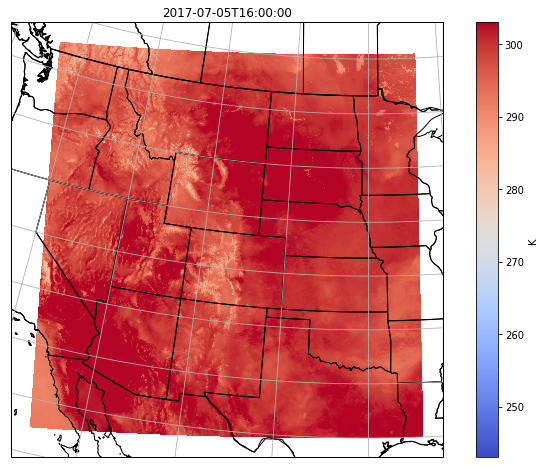

In [15]:
import cartopy.feature as cfeat
states_provinces = cfeat.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

t_step = 0

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
cmap = plt.get_cmap("coolwarm")
color_range = plt.Normalize(243, 303)
mesh = ax.pcolormesh(x, y, ncvar[t_step].squeeze(),
                     transform=hrrr_proj, zorder=0,
                     cmap=cmap, norm=color_range)

# add some common geographic features
ax.coastlines(resolution='10m', color='black', zorder=1)
ax.add_feature(states_provinces, edgecolor='black', zorder=1)
ax.add_feature(cfeat.BORDERS)

# add some lat/lon gridlines
ax.gridlines()
ax.set_title(time[t_step].isoformat())

# add a colorbar
cax = fig.colorbar(mesh)
cax.set_label(ncvar.units)

### Exercise 1

## NCSS Point Request
We can also request data for a specfici lon/lat point, across vertical coordinates or times.

In [16]:
point_query = ncss.query()
point_query.all_times()
point_query.accept('netcdf4')
point_query.variables('Temperature_isobaric', 'Dewpoint_temperature_isobaric')
point_query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
point_query.lonlat_point(lon, lat)

# get the data!
point_data = ncss.get_data(point_query)

Skew-T diagrams typical use speficic units. First, let's assign units to the variables we requested

In [17]:
# get netCDF variables
pressure = point_data["isobaric"]
temp = point_data["Temperature_isobaric"]
dewpt = point_data["Dewpoint_temperature_isobaric"]
u_cmp = point_data["u-component_of_wind_isobaric"]
v_cmp = point_data["v-component_of_wind_isobaric"]

# download data and assign the units based on the variables metadata
p = pressure[:].squeeze()[t_step, :] * units(pressure.units)
T = temp[:].squeeze()[t_step, :]  * units(temp.units)
Td = dewpt[:].squeeze()[t_step, :] * units(dewpt.units)
u = u_cmp[:].squeeze()[t_step, :] * units(u_cmp.units)
v = v_cmp[:].squeeze()[t_step, :] * units(v_cmp.units)

Now, let's change those units to what we typically see used in Skew-T diagrams

In [18]:
p = p.to(units.millibar)
T = T.to(units.degC)
Td = Td.to(units.degC)
u = u.to(units.knot)
v = v.to(units.knot)

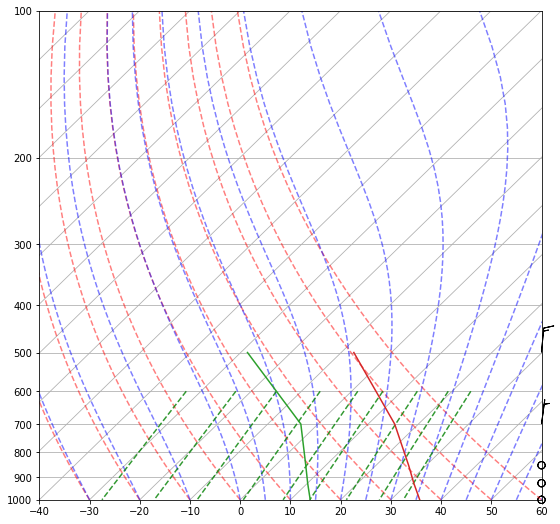

In [19]:
from metpy.calc import lcl, dry_lapse, parcel_profile
from metpy.plots import SkewT
from metpy.units import concatenate

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'tab:red')
skew.plot(p, Td, 'tab:green')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()